In [1]:
import tensorflow as tf

print(tf.__version__)

from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4
import tensorflow_addons as tfa
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from object_detection import get_bounding_box, plot_results, plot_bounding_box

HEIGHT, WIDTH = (640, 960)

2.7.0


In [18]:
HEIGHT, WIDTH = (640, 960)
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.502, 0.000, 0.000], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
def plot_results(pil_img, boxes, scores, classes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()

    for (xmin, ymin, xmax, ymax), score, cl in zip(boxes.tolist(), scores.tolist(), classes.tolist()):
        if score > 0:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=COLORS[0], linewidth=10))
            text = f'{CLASSES[cl]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
model = YOLOv4(
    input_shape=(HEIGHT, WIDTH, 3),
    anchors=YOLOV4_ANCHORS,
    num_classes=80,
    training=False,
    yolo_max_boxes=100,
    yolo_iou_threshold=0.5,
    yolo_score_threshold=0.5,
)

model.load_weights("/Users/deepakduggirala/Documents/yolov4.h5")

In [4]:
name = '1000/IMG_1626'
fname = Path('/Users/deepakduggirala/Documents/Elephants-dataset-png') / (name + '.png')
json_fname = Path('/Users/deepakduggirala/Documents/Elephants-dataset') / (name + '.json')

In [5]:
root_dir = Path('/Users/deepakduggirala/Documents/ELPephant/images')
fname = sorted(root_dir.iterdir())[4]
fname

PosixPath('/Users/deepakduggirala/Documents/ELPephant/images/1002_Cynthia I rightside_May2010.jpg')

In [6]:
image = tf.io.read_file(str(fname))
image = tf.image.decode_image(image)
image = tf.image.resize(image, (HEIGHT, WIDTH))
images = tf.expand_dims(image, axis=0) / 255.0

In [7]:
boxes, scores, classes, valid_detections = model.predict(images)
valid_detections

2022-04-30 21:28:46.803945: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([1], dtype=int32)

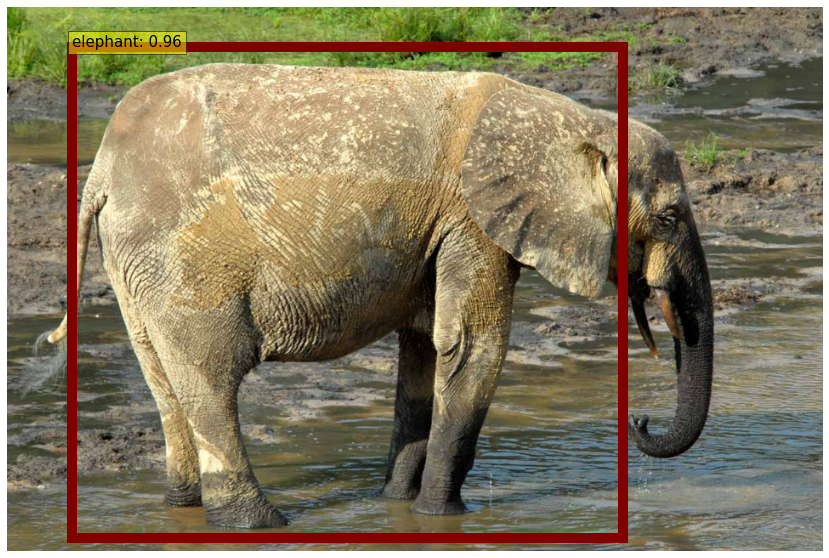

In [19]:
plot_results(
    images[0],
    boxes[0] * [WIDTH, HEIGHT, WIDTH, HEIGHT],
    scores[0],
    classes[0].astype(int),
)

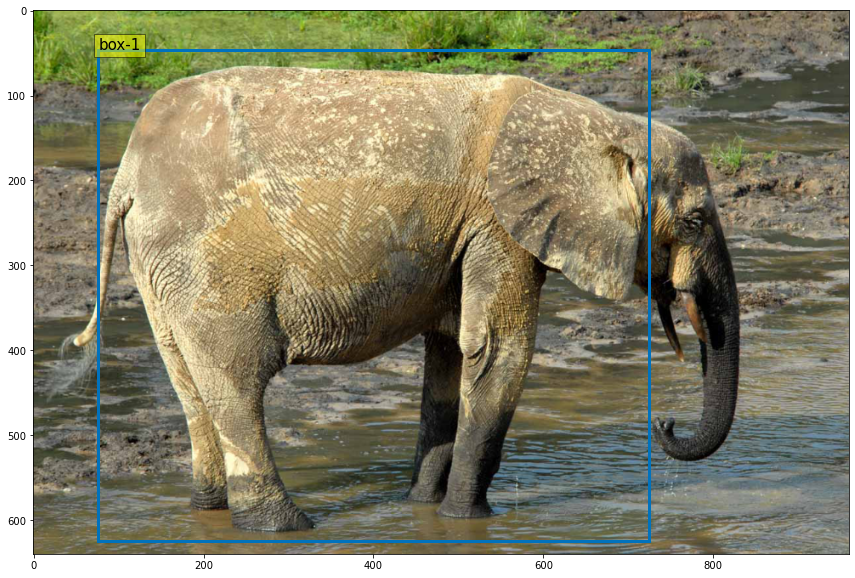

In [13]:
plot_bounding_box(images[0], boxes[0, 0].reshape(1,-1), None, True)

In [83]:
y_true, (H,W) = get_bounding_box(json_fname, normalize=True)

In [84]:
y_pred = boxes[0,0]

In [85]:
1-tfa.losses.giou_loss(y_true, y_pred).numpy()

0.7229239344596863

In [86]:
img = plt.imread(fname)

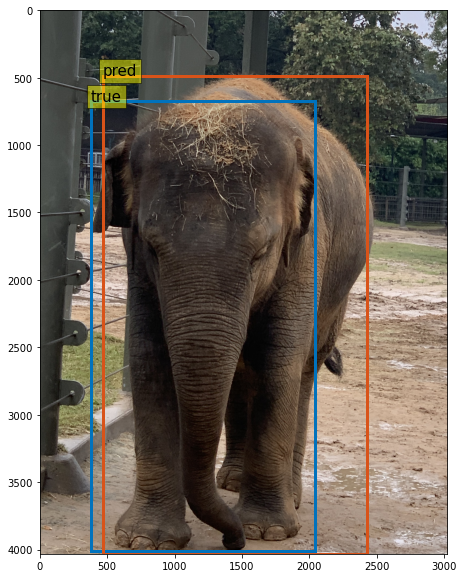

In [87]:
plot_bounding_box(img, [y_true, y_pred], ['true', 'pred'], normalized=True)

In [88]:
y_true

array([0.12491373, 0.16701173, 0.67558086, 0.99516908])

In [89]:
y_pred

array([0.15515998, 0.12008056, 0.8017739 , 1.        ], dtype=float32)

In [90]:
def iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    x_union_min, y_union_min = min(x1_min, x2_min), min(y1_min, y2_min)
    x_union_max, y_union_max = max(x1_max, x2_max), max(y1_max, y2_max)
    union_area = (x_union_max - x_union_min) * (y_union_max - y_union_min)
    
    x_intersection_min, y_intersection_min = max(x1_min, x2_min), max(y1_min, y2_min)
    x_intersection_max, y_intersection_max = min(x1_max, x2_max), min(y1_max, y2_max)
    intersection_area = (x_intersection_max - x_intersection_min) * (y_intersection_max - y_intersection_min)
    
    return intersection_area/union_area


iou(y_true, y_pred)

0.7236452500588477